# 랭그래프 

In [1]:
from dotenv import load_dotenv
import os 
from langchain_openai import AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser

load_dotenv('env', override=True)
AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
END_POINT=os.getenv('END_POINT')
MODEL_NAME=os.getenv('MODEL_NAME')
print(AZURE_OPENAI_API_KEY[:10])
print(MODEL_NAME)

AZURE_OPENAI_EMB_API_KEY = os.getenv('AZURE_OPENAI_EMB_API_KEY')
EMB_END_POINT=os.getenv('EMB_END_POINT')
EMB_MODEL_NAME=os.getenv('EMB_MODEL_NAME')

os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_TRACING_V2'] = 'true' #true, false
os.environ['LANGCHAIN_PROJECT'] = 'LANG'

if os.getenv('LANGCHAIN_TRACING_V2') == "true":
    print('랭스미스로 추적 중입니다 :', os.getenv('LANGSMITH_API_KEY')[:10])

43b13g4OZS
gpt-4.1-mini
랭스미스로 추적 중입니다 : lsv2_pt_fd


## 랭그래프 기본

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator

# 1. 상태(State) 정의 및 그래프 초기화
class State(TypedDict):
    input: str
    result: str

graph = StateGraph(State)

# 2. 노드(Node) 함수 정의
def model_node(state: State):
   
    print("모델 노드가 실행 됐습니다!")

    # 상태에 액션 기록 추가
    return {"result": "성공!!"}

# 3. 노드를 그래프로 추가
graph.add_node("model", model_node)

# 4. 엣지(Edge) 정의
graph.set_entry_point("model")
graph.add_edge("model", END)

# 5. 그래프 컴파일 및 실행
app = graph.compile()

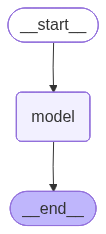

In [ ]:
# plot graph
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [4]:
result = app.invoke({'input': '입력', 'result' : ''})
print(result)

모델 노드가 실행 됐습니다!
{'input': '입력', 'result': '성공!!'}


In [5]:
for st in app.stream({'input': '입력', 'result' : ''}):
    print(st)

모델 노드가 실행 됐습니다!
{'model': {'result': '성공!!'}}


## 조건부 엣지가 있는 그래프

In [6]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator, random

# 1) 상태(State)
class State(TypedDict):
    input: str
    all_actions: Annotated[List[str], operator.add] #<-- 리듀서: 노드에서 값을 반환할 때 하는 동작

# 2) 노드(Node)
def model_node(state: State):

    print("[model] 모델이 아무것도 안했습니다!")

    return {"all_actions": ["model_decision"]}

def tool_node(state: State):

    print("[tools] 뭔가 대단한 걸 했습니다!")

    return {"all_actions": ["tool_action"]}

# 3) 조건부 엣지: 랜덤으로 바로 END 또는 tools 거쳐 END
def random_route(state: State) -> str:
    route = random.choice(["end_direct", "via_tools"])
    print(f"[route] 랜덤 결정: {route}")
    return route

# 4) 그래프 구성
graph = StateGraph(State)
graph.add_node("model", model_node)
graph.add_node("tools", tool_node)

graph.set_entry_point("model")

graph.add_conditional_edges(
    "model",
    random_route,
    {
        "end_direct": END,
        "via_tools": "tools"
    }
)

# tools → END
graph.add_edge("tools", END)

# 5) 컴파일
app = graph.compile()

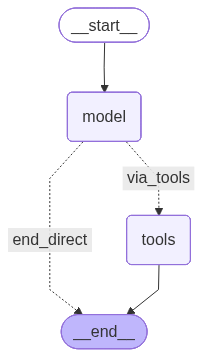

In [7]:
Image(app.get_graph().draw_mermaid_png())

In [8]:
result = app.invoke({"input": "hello", "all_actions": []})
print(result)

[model] 모델이 아무것도 안했습니다!
[route] 랜덤 결정: via_tools
[tools] 뭔가 대단한 걸 했습니다!
{'input': 'hello', 'all_actions': ['model_decision', 'tool_action']}


## 반복이 있는 그래프

In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator, random

# 1) 상태(State)
class State(TypedDict):
    input: str
    iter: int          # 반복 횟수
    all_actions: Annotated[List[str], operator.add]   #<-- 리듀서: 노드에서 값을 반환할 때 하는 동작

# 2) 노드(Node)
def model_node(state: State):

    # cur_iter = state.get("iter", 0) + 1
    iter_up = state['iter'] + 1
    print(f"[model] 모델 분기 고민 중... (iter={iter_up})")

    # 액션 로그에 기록
    return {
        "iter": iter_up,
        "all_actions": [f"model_{iter_up}"]
    }

def tool_node(state: State):
    print(f"[tools] 뭔가 대단한 걸 했습니다!")
    return {"all_actions": [f"tool_{state['iter']}"]}

# 3) 조건부 엣지
def should_continue(state: State) -> str:
    if state["iter"] >= 4:
        print("반복이 지정된 횟수를 초과했으므로 종료합니다.")
        return "end"

    return "continue"

# 4) 그래프 구성
graph = StateGraph(State)
graph.add_node("model", model_node)
graph.add_node("tools", tool_node)

graph.set_entry_point("model")
graph.add_edge("tools", "model")

graph.add_conditional_edges(
    "model",
    should_continue,
    {
        "continue": "tools", #should_continue함수의 return이 continue이면 tool로 
        "end": END           #should_continue함수의 return이 end이면 END로
    }
)

app = graph.compile()

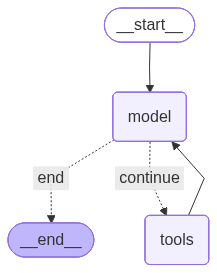

In [10]:
Image(app.get_graph().draw_mermaid_png())

In [11]:
result = app.invoke({"input": "hello", "iter": 0, "all_actions": []})
print(result)

[model] 모델 분기 고민 중... (iter=1)
[tools] 뭔가 대단한 걸 했습니다!
[model] 모델 분기 고민 중... (iter=2)
[tools] 뭔가 대단한 걸 했습니다!
[model] 모델 분기 고민 중... (iter=3)
[tools] 뭔가 대단한 걸 했습니다!
[model] 모델 분기 고민 중... (iter=4)
반복이 지정된 횟수를 초과했으므로 종료합니다.
{'input': 'hello', 'iter': 4, 'all_actions': ['model_1', 'tool_1', 'model_2', 'tool_2', 'model_3', 'tool_3', 'model_4']}


## 반복이 있는 그래프 2 - 리듀서 

이번엔 iter에 리듀서를 추가하고 삭제해봅시다. model_node를 다시 봅시다.

In [12]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator, random

# 1) 상태(State)

# 리듀서 함수 
# 이전에 state값과 현재 갱신된 state 두 개를 받아서 합치는 방법을 결정
increment = lambda old, new : old + 1  #실행될 때마다 자동 +1

class State(TypedDict):
    input: str
    iter: Annotated[int, increment]          # Annotated를 사용하면 리듀서를 설정할 수 있습니다.
    all_actions: List[str]               #<-- 이번엔 반대로 all action에 리듀서를 제거

# 2) 노드(Node)
def model_node(state: State):

    print(f"[model] 모델 분기 고민 중... (iter={state['iter']})")
    
    return { 
        "iter": None, #<-- 아무것도 리턴하지 않아도 리듀서에 의해서 값이 1 증가
        "all_actions": [f"model_{state['iter']}"]
    }

def tool_node(state: State):
    print(f"[tools] 뭔가 대단한 걸 했습니다!")
    return {"all_actions": [f"tool_{state['iter']}"]}

# 3) 조건부 엣지
def should_continue(state: State) -> str:
    if state["iter"] >= 4:
        print("반복이 지정된 횟수를 초과했으므로 종료합니다.")
        return "end"

    return "continue"

# 4) 그래프 구성
graph = StateGraph(State)
graph.add_node("model", model_node)
graph.add_node("tools", tool_node)

graph.set_entry_point("model")
graph.add_edge("tools", "model")

graph.add_conditional_edges(
    "model",
    should_continue,
    {
        "continue": "tools",
        "end": END
    }
)

app = graph.compile()

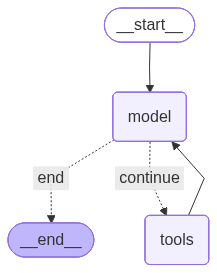

In [13]:
Image(app.get_graph().draw_mermaid_png())

all_actions에 리듀서가 없으므로 노드가 리턴한 최신 값으로 갱신됨

In [14]:
result = app.invoke({"input": "hello", "iter": 0, "all_actions": []})
print(result)

[model] 모델 분기 고민 중... (iter=1)
[tools] 뭔가 대단한 걸 했습니다!
[model] 모델 분기 고민 중... (iter=2)
[tools] 뭔가 대단한 걸 했습니다!
[model] 모델 분기 고민 중... (iter=3)
반복이 지정된 횟수를 초과했으므로 종료합니다.
{'input': 'hello', 'iter': 4, 'all_actions': ['model_3']}


## 나이별 용어 설명기 만들기

In [15]:
from typing import TypedDict, Annotated, List, Optional
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)

# 1) 상태 정의
class State(TypedDict):
    term: str                       # 설명할 용어 
    age: int                        # 대상 나이
    audience: Optional[str]         # 분기 결과: "kinder"|"elementary"|"teen"|"expert"
    result: Optional[str]           # 최종 설명문
    logs: Optional[str]            # 누가 수행되었는지 로그

# 2) 라우터(조건부 분기 기준 계산)
def audience_router(state: State) -> dict:
    age = state["age"]
    if age < 8:
        audience = "kinder"
    elif age <= 13:
        audience = "elementary"
    elif age <= 20:
        audience = "teen"
    else:
        audience = "expert"
    return {"audience": audience, "logs": [f"[route]"]}

# 3) 각 타깃별 프롬프트 (LLM은 동일, 톤만 바꿈)
prompt_kinder = ChatPromptTemplate.from_messages([
    ("system",
     "너는 유치원생에게 친절하고 재미있게 설명하는 선생님이야. "
     "어려운 말은 쓰지 말고, 짧고 쉽게, 비유를 꼭 하나 써줘."),
    ("user", "단어: {term}\n를 {age}살 유치원생에게 설명해줘. ")
])

prompt_elementary = ChatPromptTemplate.from_messages([
    ("system",
     "너는 초등학생에게 설명하는 선생님이야. 핵심 정의 1~2문장 + 쉬운 예시를 포함해."),
    ("user", "용어: {term}\n를 {age}살 초등학생 수준으로 설명해줘.")
])

prompt_teen = ChatPromptTemplate.from_messages([
    ("system",
     "너는 중고등학생에게 설명하는 선생님이야. "
     "정의→원리→간단한 응용 순서로 5~7문장 내로 정리해."
     "교과과정에서 어떤 부분을 더 학습하면 좋은지도 간단하게 소개해줘"),
    ("user", "용어: {term}\n를 {age}살 중고등학생 수준으로 설명해줘.")
])

prompt_expert = ChatPromptTemplate.from_messages([
    ("system",
     "너는 전문가가 전문가에게 설명하듯 기술적으로 설명해. "
     "핵심 개념, 수식/알고리즘 포인트, 실무적 고려사항을 간결히."),
    ("user", "용어: {term}\n를 전문가 수준으로 설명해줘.")
])

def explain_kinder(state: State) -> dict:
    out = (prompt_kinder | llm).invoke({"term": state["term"], "age" : state['age']})
    return {"result": out.content, "logs": ["[kinder]"]}

def explain_elementary(state: State) -> dict:
    out = (prompt_elementary | llm).invoke({"term": state["term"], "age" : state['age']})
    return {"result": out.content, "logs": ["[elementary]"]}

def explain_teen(state: State) -> dict:
    out = (prompt_teen | llm).invoke({"term": state["term"], "age" : state['age']})
    return {"result": out.content, "logs": ["[teen]"]}

def explain_expert(state: State) -> dict:
    out = (prompt_expert | llm).invoke({"term": state["term"]})
    return {"result": out.content, "logs": ["[expert]"]}

# 4) 그래프 구성 (조건부 엣지)
graph = StateGraph(State)
graph.add_node("route", audience_router)
graph.add_node("kinder", explain_kinder)
graph.add_node("elementary", explain_elementary)
graph.add_node("teen", explain_teen)
graph.add_node("expert", explain_expert)

graph.set_entry_point("route")

def route_by_age(state: State) -> str:
    return state["audience"] or "expert"

graph.add_conditional_edges("route", route_by_age, {
    "kinder": "kinder",
    "elementary": "elementary",
    "teen": "teen",
    "expert": "expert",
})

# 각 분기 종료
graph.add_edge("kinder", END)
graph.add_edge("elementary", END)
graph.add_edge("teen", END)
graph.add_edge("expert", END)

app = graph.compile()

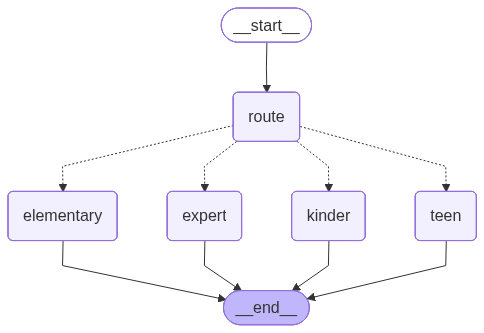

In [16]:
Image(app.get_graph().draw_mermaid_png())

In [17]:
for age in (4, 10, 16, 30):
    init_state = {"term": "인공지능이 뭐야?", "age": age, "audience": None, "result": None, "logs": None}
    out = app.invoke(init_state)
    print("\n===========\n age:", age, "audience:", out["audience"], "===")
    print(out["result"])
    print("LOGS:", out["logs"])


 age: 4 audience: kinder ===
인공지능은 똑똑한 로봇 친구야! 마치 장난감 자동차가 혼자 움직이는 것처럼, 인공지능은 컴퓨터가 똑똑하게 생각하고 도와주는 거야. 그래서 우리가 물어보면 답도 해주고, 게임도 같이 할 수 있어!
LOGS: ['[kinder]']

 age: 10 audience: elementary ===
인공지능은 컴퓨터가 사람처럼 똑똑하게 생각하고 배우는 기술이에요. 예를 들어, 스마트폰에서 말하면 답해 주거나, 게임에서 적을 알아서 이기는 것도 인공지능 덕분이에요.
LOGS: ['[elementary]']

 age: 16 audience: teen ===
인공지능이란 컴퓨터나 기계가 사람처럼 생각하고 배우는 능력을 가지도록 만드는 기술을 말해. 원리는 컴퓨터에 많은 데이터를 주고, 그 데이터를 바탕으로 스스로 규칙을 찾아 문제를 해결하게 하는 거야. 예를 들어, 인공지능은 사진 속에서 고양이와 강아지를 구분하거나, 음성으로 명령을 이해해서 스마트폰을 작동시킬 수 있어. 이렇게 인공지능은 우리 생활을 더 편리하게 만들어 주지. 더 깊게 배우고 싶다면 중학교나 고등학교에서 배우는 ‘컴퓨터 과학’과 ‘수학(특히 확률과 통계, 알고리즘)’을 공부하면 좋아. 이 과목들이 인공지능의 원리를 이해하는 데 큰 도움이 될 거야.
LOGS: ['[teen]']

 age: 30 audience: expert ===
인공지능(AI, Artificial Intelligence)은 인간의 인지능력, 학습, 추론, 문제 해결, 자연어 이해 등 지능적 행위를 컴퓨터 시스템이 모방하도록 설계된 기술 및 이론의 총체다. 

핵심 개념:
- 지능적 에이전트: 환경을 인지하고 목표 달성을 위해 행동하는 시스템
- 학습 알고리즘: 데이터로부터 패턴을 추출해 모델을 개선하는 과정 (예: 지도학습, 비지도학습, 강화학습)
- 추론 및 의사결정: 논리적 규칙이나 확률 모델을 통해 불확실성 하에서 판단 수행
- 표현 및 지식 표현: 도메인 지식을 구조화하여 

## 랭그래프로 RAG 만들기 

In [21]:
import os
from typing import List, TypedDict

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI

from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

In [26]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("pdf/인터넷서비스_이용약관.pdf", mode="page") 
docs = loader.load()

print('데이터 로드 완료')

from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=50,
    separators=["\n\n", "\n", "  ", " "]
)
splits = splitter.split_documents(docs)

print('분할 완료')

from langchain_community.vectorstores import Chroma, FAISS
from langchain_openai import AzureOpenAIEmbeddings

emb = AzureOpenAIEmbeddings(
    model=EMB_MODEL_NAME,                      
    api_key=AZURE_OPENAI_EMB_API_KEY,
    azure_endpoint=EMB_END_POINT,
    api_version="2024-08-01-preview"
)
vectordb = FAISS.from_documents(splits,emb)
retriever = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 10})
print('임베딩 및 저장 완료')

데이터 로드 완료
분할 완료
임베딩 및 저장 완료


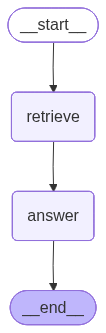

In [29]:
class State(TypedDict):
    question: str
    context: str
    answer: str

def build_context(docs: List[Document]) -> str:
    return "\n\n-----\n\n".join(d.page_content + f"\n\n <출처>: {d.metadata['source']} - {d.metadata['page']}" for d in docs)

def retriever_node(state: State) -> State:
    found = retriever.invoke(state["question"])
    return {"context": build_context(found)}

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.1,
)

prompt = ChatPromptTemplate.from_messages([
    ("system",
     "너는 통신사 고객상담을 위한 이용약관 문서 기반 QA 어시스턴트다. 아래 규칙을 지켜라.\n"
     "1) 제공된 컨텍스트(표/본문)에서만 근거를 찾아 답한다.\n"
     "2) 컨택스트 내에 해당하는 정보가 없으면 모른다고 말한다. 추측 금지.\n"
     "3) 숫자/조건/예외는 정확히 인용하라.\n"
     "4) 표 내용이라면 행/열 헤더를 함께 언급해 맥락을 명확히 한다.\n"
     "5) 마지막에 출처 파일과 페이지를 함께 제시한다.\n"),
    ("human", 
     "질문: {question}\n\n"
     "컨텍스트:\n{context}\n\n"
     "답변: ")
])

def answer_generator_node(state: State) -> State:
    out = (prompt | llm  | StrOutputParser()).invoke({"question": state["question"], "context": state["context"]})
    return {"answer": out}

graph = StateGraph(State)
graph.add_node("retrieve", retriever_node)
graph.add_node("answer", answer_generator_node)

graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "answer")
graph.add_edge("answer", END)

app = graph.compile()
app

In [30]:
result = app.invoke({"question": "오피스IP팩은 어떤 서비스야?"})
print(result["answer"])

오피스IP팩은 다수의 IP를 필요로 하는 소규모 오피스 대상 서비스입니다. 이 서비스는 개인, 개인사업자, 법인사업자를 대상으로 하며, KT의 초고속인터넷 회선 서비스 기반으로 제공됩니다. 오피스IP 서비스는 인터넷이 일시정지, 이용정지, 설비정지되면 IP서비스도 사용이 불가하며 중단기간은 실사용 기간에서 제외됩니다. 또한, 오피스IP 서비스는 사용 단말 수를 제한하지 않습니다.

오피스IP넷 플러스(GiGA WiFi premium)와 오피스넷 와이파이(GiGA WiFi home) 등 다양한 상품이 있으며, 각각 KT WiFi AP 장비 또는 KT GiGA WiFi Secure 장비를 함께 제공합니다. 기본적으로 유동IP로 인터넷서비스를 제공하며, 고정IP는 기본상품 기반으로 회선 당 최대 3개까지 제공됩니다.

요금은 IP당으로 책정되며, 예를 들어 오피스넷 슈퍼프리미엄은 10G 속도에 132,000원, 오피스넷 에센스는 1G 속도에 64,900원 등 다양한 속도와 요금대가 있습니다.

요약하면, 오피스IP팩은 소규모 오피스에서 다수의 IP를 필요로 할 때 적합한 KT의 인터넷 서비스로, 고정IP 또는 유동IP를 선택할 수 있고, WiFi 장비와 보안 솔루션을 함께 제공하는 상품군입니다.

출처: pdf/인터넷서비스_이용약관.pdf, 페이지 199~206, 210~211
